## Week 10 Homework

---

### Q1: perform Bayesian Logistic Regression

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


In [4]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

titanic = pd.read_csv("train.csv")

# We'll do a simple logistic regression: Survived ~ Sex + Age + Pclass

# Clean the data: drop rows with missing Age
titanic = titanic.dropna(subset=["Age"])

# Convert Sex to a numeric indicator (0 = male, 1 = female)
titanic["Sex_encoded"] = (titanic["Sex"] == "female").astype(int)

# Create the feature matrix (X) and the outcome vector (y)
X = titanic[["Sex_encoded", "Age", "Pclass"]].values
y = titanic["Survived"].values

# Standardize or scale features if desired (often helps sampling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[:, 1:2] = scaler.fit_transform(X[:, 1:2])


In [5]:
with pm.Model() as logistic_model:
    # Number of predictors (p)
    p = X.shape[1]

    # Priors for the coefficients (betas)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)

    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Linear predictor
    logit_p = intercept + pm.math.dot(X, betas)

    # Inverse logit to get probabilities
    theta = pm.Deterministic('theta', pm.math.sigmoid(logit_p))

    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=theta, observed=y)

    # MCMC sampling
    trace = pm.sample(draws=2000, tune=1000, target_accept=0.9, random_seed=42)


Output()

In [7]:
# Summarize the posterior
az.summary(trace, var_names=["intercept", "betas"], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.293,0.277,0.768,1.809,0.006,0.004,2273.869,2387.199,1.001
betas[0],2.439,0.201,2.051,2.808,0.004,0.003,2045.276,1840.317,1.002
betas[1],-0.507,0.106,-0.710,-0.308,0.002,0.001,2555.739,2462.200,1.002
betas[2],-1.212,0.127,-1.441,-0.973,0.003,0.002,2103.028,2375.893,1.001


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

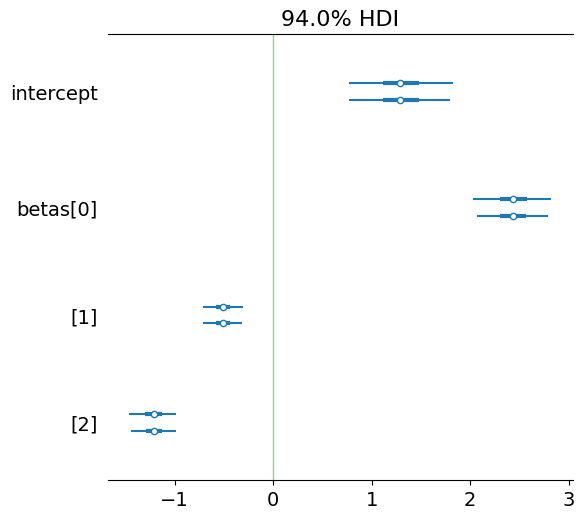

In [11]:
az.plot_forest(trace, var_names=["intercept", "betas"], rope = (0,0))

The model suggests that the first predictor increases the log-odds of the outcome, while the second and third predictors decrease it. All parameter estimates are precise (low MCSEs), have high effective sample sizes, and the convergence diagnostics (r_hat values) indicate that the MCMC chains have converged well. None of the credible intervals contain 0 signfiying the signficance of the parameter values.

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

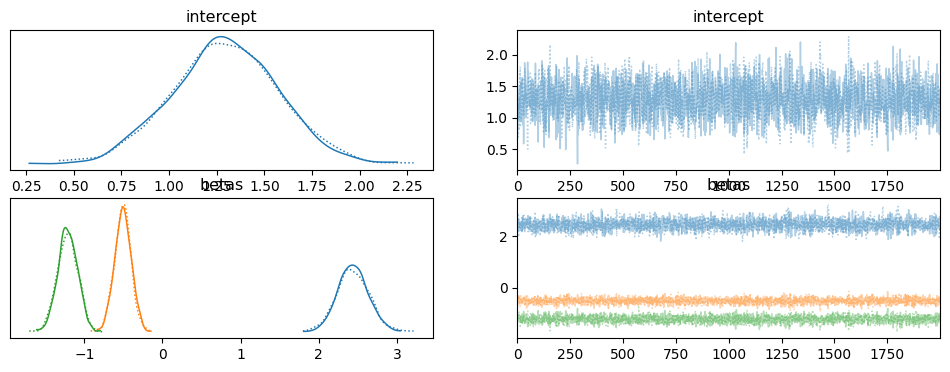

In [8]:
az.plot_trace(trace, var_names=["intercept", "betas"])

Each parameter (the intercept and three βs) has a well-defined, unimodal posterior distribution with little overlap near zero.

The intercept peaks around 1.3 to 1.4, suggesting a positive baseline log-odds.

One coefficient is clearly positive (peaking around 2.4), while the other two are negative (peaking around -0.5 and -1.2), indicating distinct positive/negative effects.

Overall, the model finds strong evidence that one predictor increases the log-odds of the outcome, while two predictors decrease it. The well-mixed chains and unimodal posteriors suggest the results are stable and reliable.

array([[<Axes: title={'center': 'intercept\n0'}>,
        <Axes: title={'center': 'intercept\n1'}>,
        <Axes: title={'center': 'betas\n0, 0'}>,
        <Axes: title={'center': 'betas\n0, 1'}>],
       [<Axes: title={'center': 'betas\n0, 2'}>,
        <Axes: title={'center': 'betas\n1, 0'}>,
        <Axes: title={'center': 'betas\n1, 1'}>,
        <Axes: title={'center': 'betas\n1, 2'}>]], dtype=object)

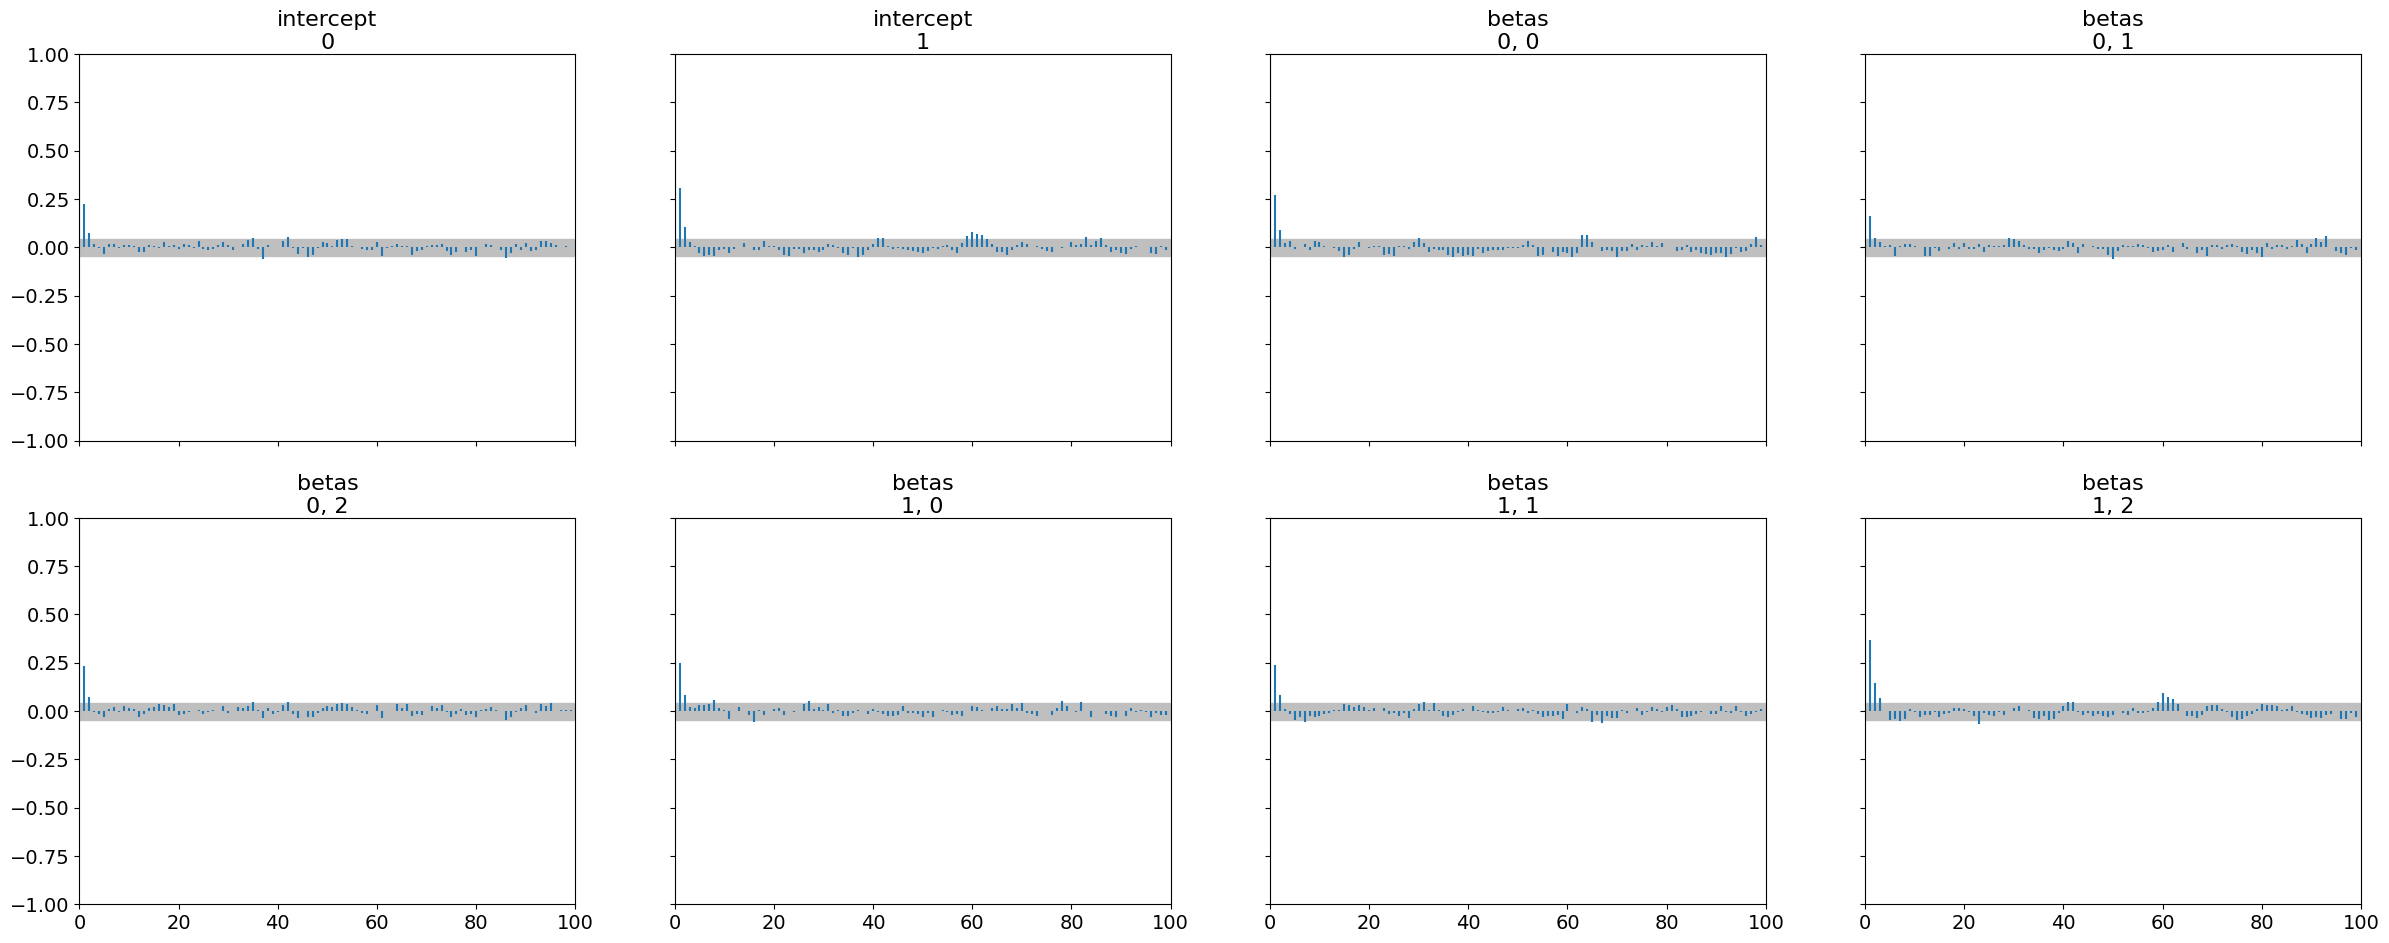

In [9]:
az.plot_autocorr(trace, var_names=["intercept", "betas"])

Each parameter’s autocorrelation settles near zero for lags > 0 which indicates a good level of mixing of the chain’s.

### Q2: perform Bayesian Multivariate Regression

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and
    - report on your findings and based on that
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics



In [18]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [19]:
import time
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def fit_mvn_model(df, predictors, outcomes, draws=500, tune=500):
    """
    Fits a Bayesian multivariate regression model.

    The model:
      - Adds an intercept,
      - Standardizes predictors,
      - Uses an LKJCholeskyCov prior for the covariance of the outcomes,
      - Uses a Normal prior for regression coefficients,
      - And a multivariate Normal likelihood.

    Parameters:
      df: DataFrame containing the data.
      predictors: List of predictor column names.
      outcomes: List of outcome column names.
      draws: Number of posterior draws.
      tune: Number of tuning iterations.

    Returns:
      model: the PyMC model,
      trace: the MCMC trace,
      runtime: elapsed time in seconds.
    """
    # Work on a copy and add an intercept column.
    df_temp = df.copy()
    df_temp["Intercept"] = 1.0
    pred_list = ["Intercept"] + predictors

    # Construct design matrices.
    X = df_temp[pred_list].values  # shape: (n, p)
    Y = df_temp[outcomes].values    # shape: (n, m)
    n, p_dim = X.shape
    m_dim = len(outcomes)

    # Standardize predictors.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    start_time = time.time()
    with pm.Model() as model:
        # Define the covariance via an LKJ prior.
        packed_L = pm.LKJCholeskyCov(
            'packed_L',
            n=m_dim,
            eta=2.0,
            sd_dist=pm.Exponential.dist(1.0, shape=m_dim),
            compute_corr=False
        )
        # Expand the packed triangular matrix to get the lower-triangular Cholesky factor.
        L = pm.expand_packed_triangular(m_dim, packed_L)
        Sigma = pm.Deterministic('Sigma', L @ L.T)

        # Regression coefficients (p x m).
        betas = pm.Normal('betas', mu=0, sigma=1, shape=(p_dim, m_dim))

        # Linear predictor.
        mu_pred = pm.math.dot(X_scaled, betas)

        # Multivariate Normal likelihood.
        Y_obs = pm.MvNormal('Y_obs', mu=mu_pred, chol=L, observed=Y)

        trace = pm.sample(draws=draws, tune=tune, chains=4, target_accept=0.9, random_seed=42)
    runtime = time.time() - start_time
    return model, trace, runtime


In [20]:
# ------------------------------
# 1. Load and Prepare the Data
# ------------------------------
df = pd.read_csv("/content/energy_efficiency_data.csv")
print("Head of energy efficiency data:")
print(df.head())

# Select three predictors for simplicity.
predictor_cols = ["Relative_Compactness", "Surface_Area", "Wall_Area"]
# Use two outcomes.
outcome_cols = ["Heating_Load", "Cooling_Load"]

# For our experiments we assume the full dataset is large enough.
# First, we downsample to 200 observations for exploratory purposes.
n_total = df.shape[0]
if n_total > 200:
    idx = np.random.choice(n_total, size=200, replace=False)
    df = df.iloc[idx]

# Check dimensions after initial downsampling.
print(f"Data after initial downsampling: {df.shape}")


Head of energy efficiency data:
   Relative_Compactness  Surface_Area  Wall_Area  Roof_Area  Overall_Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   

   Orientation  Glazing_Area  Glazing_Area_Distribution  Heating_Load  \
0            2           0.0                          0         15.55   
1            3           0.0                          0         15.55   
2            4           0.0                          0         15.55   
3            5           0.0                          0         15.55   
4            2           0.0                          0         20.84   

   Cooling_Load  
0         21.33  
1         21.33  


In [21]:
# 2. Loop Over Different Sample Sizes
n_values = [10, 20, 50]
results = []

for n_val in n_values:
    # Randomly sample n_val rows.
    df_sub = df.sample(n=n_val, random_state=42)
    model, trace, runtime = fit_mvn_model(df_sub, predictor_cols, outcome_cols, draws=500, tune=500)

    # Summarize the trace for regression coefficients (betas) and covariance (Sigma).
    summary_df = az.summary(trace, var_names=["betas", "Sigma"], round_to=2)
    print(f"=== Sample size n={n_val} ===")
    print(summary_df)
    print(f"Runtime: {runtime:.2f} seconds\n")

    results.append({
        "n": n_val,
        "p": len(["Intercept"] + predictor_cols),  # including intercept
        "m": len(outcome_cols),
        "runtime": runtime,
        "summary": summary_df
    })


Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


=== Sample size n=10 ===
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]    0.02   0.98   -1.80     1.90       0.02     0.02   2566.88   
betas[0, 1]   -0.03   1.00   -1.95     1.85       0.02     0.02   2043.33   
betas[1, 0]    0.47   0.88   -1.21     2.08       0.02     0.02   1442.78   
betas[1, 1]   -0.08   0.90   -1.56     1.76       0.02     0.02   1503.43   
betas[2, 0]   -0.25   0.83   -1.71     1.46       0.02     0.02   1815.79   
betas[2, 1]   -0.13   0.91   -1.75     1.65       0.02     0.02   1762.09   
betas[3, 0]    0.43   0.78   -1.03     1.89       0.02     0.02   1799.85   
betas[3, 1]   -0.38   0.84   -1.90     1.24       0.02     0.02   1794.97   
Sigma[0, 0]  172.39  33.54  109.97   232.02       0.97     0.69   1190.15   
Sigma[0, 1]  189.54  36.93  126.52   260.97       1.08     0.77   1193.63   
Sigma[1, 0]  189.54  36.93  126.52   260.97       1.08     0.77   1193.63   
Sigma[1, 1]  216.49  42.03  140.64   291.73       1

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

=== Sample size n=20 ===
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]   -0.02   1.01   -1.95     1.83       0.02     0.02   3259.84   
betas[0, 1]    0.01   0.99   -1.76     2.01       0.02     0.02   2238.56   
betas[1, 0]    0.63   0.86   -0.99     2.23       0.02     0.02   1961.23   
betas[1, 1]   -0.12   0.89   -1.68     1.60       0.02     0.02   1934.71   
betas[2, 0]   -0.25   0.81   -1.74     1.30       0.02     0.02   1814.13   
betas[2, 1]   -0.26   0.88   -1.90     1.45       0.02     0.02   2042.67   
betas[3, 0]    0.59   0.69   -0.72     1.89       0.02     0.01   1322.46   
betas[3, 1]   -0.29   0.76   -1.61     1.31       0.02     0.02   1336.24   
Sigma[0, 0]  236.46  39.47  170.45   311.00       1.30     0.92    913.48   
Sigma[0, 1]  267.03  44.62  193.81   353.30       1.47     1.04    913.27   
Sigma[1, 0]  267.03  44.62  193.81   353.30       1.47     1.04    913.27   
Sigma[1, 1]  304.50  50.86  220.03   401.74       1

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

=== Sample size n=50 ===
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]    0.02   1.00   -1.87     1.96       0.02     0.03   2547.81   
betas[0, 1]   -0.01   0.98   -1.79     1.95       0.02     0.02   2064.05   
betas[1, 0]    0.61   0.82   -0.77     2.23       0.02     0.02   1675.94   
betas[1, 1]    0.14   0.83   -1.39     1.66       0.02     0.02   1805.49   
betas[2, 0]   -0.56   0.79   -2.02     0.97       0.02     0.02   1717.69   
betas[2, 1]   -0.23   0.86   -1.87     1.32       0.02     0.02   1934.78   
betas[3, 0]    0.90   0.65   -0.41     1.99       0.02     0.01   1438.85   
betas[3, 1]   -0.31   0.72   -1.68     0.98       0.02     0.02   1386.35   
Sigma[0, 0]  355.28  47.37  263.11   437.86       1.29     0.92   1380.70   
Sigma[0, 1]  392.13  52.33  302.51   497.64       1.43     1.02   1383.27   
Sigma[1, 0]  392.13  52.33  302.51   497.64       1.43     1.02   1383.27   
Sigma[1, 1]  435.70  58.10  326.12   542.33       1

In [22]:
# 3. Create a DataFrame to Compare Runtimes
# ------------------------------
results_df = pd.DataFrame([{
    "n": r["n"],
    "p": r["p"],
    "m": r["m"],
    "runtime": r["runtime"]
} for r in results])
print("Runtime Comparison:")
print(results_df)


Runtime Comparison:
    n  p  m     runtime
0  10  4  2  135.352369
1  20  4  2  181.853951
2  50  4  2  209.285719


Overall, sampling takes quite a long time. The multivariate model involves a matrix multiplication, a multivariate normal likelihood, and a Cholesky decomposition of the covariance matrix, which can be computationally intensive. The time increases with sample size. We will choose model with n = 10 since its the fastest.

In [23]:
# 4. Extract and Compare Regression Coefficients
betas_comparison = []

for res in results:
    summary_df = res["summary"]
    # Regression coefficients are labeled with the prefix "betas".
    betas_summary = summary_df[summary_df.index.str.startswith("betas")]
    for param in betas_summary.index:
        betas_comparison.append({
            "n": res["n"],
            "p": res["p"],
            "m": res["m"],
            "parameter": param,
            "mean": betas_summary.loc[param, "mean"]
        })

betas_df = pd.DataFrame(betas_comparison)
print("Regression Coefficient Comparison:")
print(betas_df)

Regression Coefficient Comparison:
     n  p  m    parameter  mean
0   10  4  2  betas[0, 0]  0.02
1   10  4  2  betas[0, 1] -0.03
2   10  4  2  betas[1, 0]  0.47
3   10  4  2  betas[1, 1] -0.08
4   10  4  2  betas[2, 0] -0.25
5   10  4  2  betas[2, 1] -0.13
6   10  4  2  betas[3, 0]  0.43
7   10  4  2  betas[3, 1] -0.38
8   20  4  2  betas[0, 0] -0.02
9   20  4  2  betas[0, 1]  0.01
10  20  4  2  betas[1, 0]  0.63
11  20  4  2  betas[1, 1] -0.12
12  20  4  2  betas[2, 0] -0.25
13  20  4  2  betas[2, 1] -0.26
14  20  4  2  betas[3, 0]  0.59
15  20  4  2  betas[3, 1] -0.29
16  50  4  2  betas[0, 0]  0.02
17  50  4  2  betas[0, 1] -0.01
18  50  4  2  betas[1, 0]  0.61
19  50  4  2  betas[1, 1]  0.14
20  50  4  2  betas[2, 0] -0.56
21  50  4  2  betas[2, 1] -0.23
22  50  4  2  betas[3, 0]  0.90
23  50  4  2  betas[3, 1] -0.31


Overall we see that for a sample size of 20 we have slighlty better converging and closer r hat values to 1 and larger effective sample sizes. However the different is not too large and smaller sizes of 15 and 10 can be used.

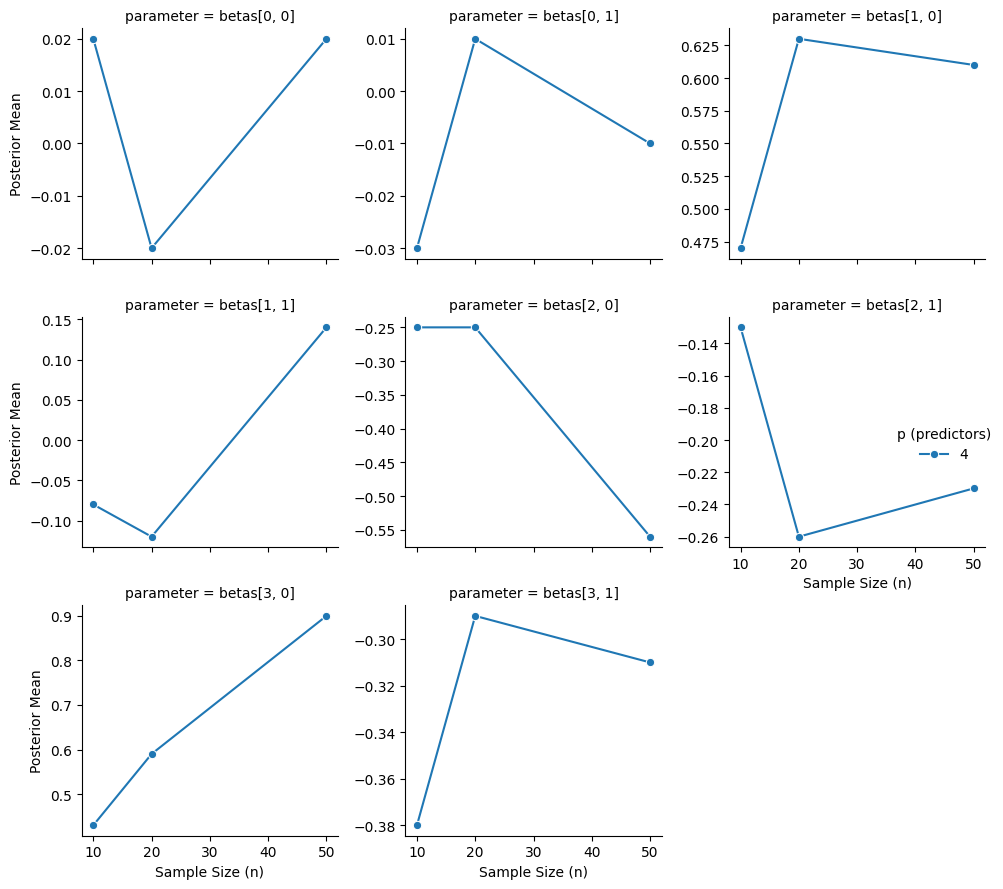

In [26]:
g = sns.FacetGrid(
    data=betas_df,
    col="parameter",    # one subplot per coefficient
    hue="p",            # color by the number of predictors (here it is constant)
    sharey=False,
    col_wrap=3
)
g.map(sns.lineplot, "n", "mean", marker="o")
g.add_legend(title="p (predictors)")
g.set_axis_labels("Sample Size (n)", "Posterior Mean")
plt.tight_layout()
plt.show()

Sample size clearly greatly effects parameter values. Each parameter is differently affected by sample size.

In [31]:
df_sub = df.sample(n=10, random_state=42)
model, trace, runtime = fit_mvn_model(df_sub, predictor_cols, outcome_cols, draws=500, tune=500)

summary_df = az.summary(trace, var_names=["betas", "Sigma"], round_to=2)
print(f"=== Sample size n=10 ===")
print(summary_df)
print(f"Runtime: {runtime:.2f} seconds\n")

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


=== Sample size n=10 ===
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]    0.02   0.98   -1.80     1.90       0.02     0.02   2566.88   
betas[0, 1]   -0.03   1.00   -1.95     1.85       0.02     0.02   2043.33   
betas[1, 0]    0.47   0.88   -1.21     2.08       0.02     0.02   1442.78   
betas[1, 1]   -0.08   0.90   -1.56     1.76       0.02     0.02   1503.43   
betas[2, 0]   -0.25   0.83   -1.71     1.46       0.02     0.02   1815.79   
betas[2, 1]   -0.13   0.91   -1.75     1.65       0.02     0.02   1762.09   
betas[3, 0]    0.43   0.78   -1.03     1.89       0.02     0.02   1799.85   
betas[3, 1]   -0.38   0.84   -1.90     1.24       0.02     0.02   1794.97   
Sigma[0, 0]  172.39  33.54  109.97   232.02       0.97     0.69   1190.15   
Sigma[0, 1]  189.54  36.93  126.52   260.97       1.08     0.77   1193.63   
Sigma[1, 0]  189.54  36.93  126.52   260.97       1.08     0.77   1193.63   
Sigma[1, 1]  216.49  42.03  140.64   291.73       1

In [30]:
# Summarize the posterior estimates for coefficients and the Cholesky factor
az.summary(trace, var_names=["betas", "Sigma"], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",0.019,0.980,-1.796,1.901,0.019,0.022,2566.875,1361.649,1.001
"betas[0, 1]",-0.025,0.997,-1.946,1.849,0.022,0.024,2043.333,1343.372,1.003
"betas[1, 0]",0.471,0.876,-1.212,2.076,0.023,0.020,1442.785,1353.835,1.003
"betas[1, 1]",-0.084,0.895,-1.560,1.763,0.023,0.024,1503.428,1090.619,1.004
"betas[2, 0]",-0.245,0.831,-1.713,1.464,0.020,0.019,1815.794,976.615,1.002
"betas[2, 1]",-0.126,0.910,-1.747,1.650,0.022,0.022,1762.086,1197.973,1.001
"betas[3, 0]",0.431,0.784,-1.028,1.887,0.019,0.018,1799.852,1140.538,1.002
"betas[3, 1]",-0.385,0.840,-1.900,1.244,0.020,0.019,1794.974,1407.257,1.004
"Sigma[0, 0]",172.387,33.543,109.967,232.018,0.973,0.694,1190.149,820.548,1.003
"Sigma[0, 1]",189.538,36.931,126.516,260.969,1.081,0.774,1193.632,903.505,1.003


r_hat≈1 and effective sample sizes (ESS) are sufficiently large.

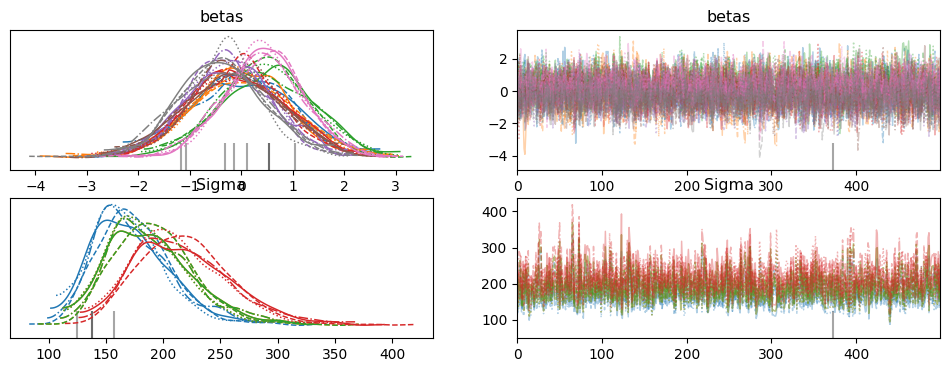

In [29]:
az.plot_trace(trace, var_names=["betas", "Sigma"])
plt.show()

The multiple colors overlapping in each trace panel, with no single chain diverging. That typically indicates the sampler is exploring the parameter space consistently.

Most of the density plots are single-peaked, suggesting the parameters are not multimodal.

The bottom-left distributions (for Sigma) are slightly right skewed. This is normal in multivariate models, especially if the data doesn’t strongly fix those variances/correlations

### Q3: perform Bayesian Multivariate Classification

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and
    - report on your findings and based on that
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


In [4]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [5]:
# 1. Load and Prepare the Data
df = pd.read_csv("/content/q3.csv")
print(df.head())

# The dataset has the following columns:
# 'id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'

# Create three numeric features from the comment text:
df["comment_length"] = df["comment_text"].str.len()
df["num_exclamation"] = df["comment_text"].str.count("!")
df["num_uppercase"] = df["comment_text"].str.findall(r"[A-Z]").str.len()

# Define outcome variables (6 binary labels)
outcome_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
Y = df[outcome_cols].values  # shape (n, m) with m = 6

# Define predictor variables (using our new numeric features)
predictor_cols = ["comment_length", "num_exclamation", "num_uppercase"]
X = df[predictor_cols].values  # shape (n, p) with p = 3


                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [11]:
import time
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

def fit_multivariate_classification(df, predictors, outcomes, draws=500, tune=300):
    """
    Fits a Bayesian multivariate classification model using a latent variable approach
    with noncentered parameterization.

    The function:
      - Adds an intercept,
      - Standardizes the predictors,
      - Constructs design matrices X and Y,
      - For multiple binary outcomes, uses:
            B ~ Normal(0,1) for coefficients,
            An LKJCholeskyCov prior to model the latent covariance,
            z_raw ~ N(0,I) and then Z = mu + dot(z_raw, L.T) (noncentered),
            And a Bernoulli likelihood with logit_p = Z[:, i] for each outcome dimension.

    Returns:
      model: the PyMC model,
      trace: the MCMC trace,
      runtime: total time in seconds.
    """
    # Work on a copy and add an intercept
    df_temp = df.copy()
    df_temp["Intercept"] = 1.0
    pred_list = ["Intercept"] + predictors

    # Construct design matrices.
    X = df_temp[pred_list].values      # shape: (n, p)
    Y = df_temp[outcomes].values        # shape: (n, m)
    n, p_dim = X.shape
    m_dim = len(outcomes)

    # Standardize predictors for better sampling performance.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    start_time = time.time()
    with pm.Model() as model:
        # For multiple binary outcomes, we use a latent variable approach.
        # Coefficient matrix: (p_dim x m_dim)
        B = pm.Normal("B", mu=0, sigma=1, shape=(p_dim, m_dim))
        mu = pm.math.dot(X_scaled, B)  # shape: (n, m_dim)

        # Define the Cholesky factor via an LKJ prior.
        packed_L = pm.LKJCholeskyCov(
            "packed_L",
            n=m_dim,
            eta=2.0,
            sd_dist=pm.Exponential.dist(1.0, shape=m_dim),
            compute_corr=False
        )
        L = pm.expand_packed_triangular(m_dim, packed_L)
        Sigma = pm.Deterministic("Sigma", L @ L.T)

        # Noncentered parameterization:
        # z_raw ~ N(0, I) and define latent variable Z = mu + dot(z_raw, L.T)
        z_raw = pm.Normal("z_raw", mu=0, sigma=1, shape=(n, m_dim))
        Z = pm.Deterministic("Z", mu + pm.math.dot(z_raw, L.T))

        # Bernoulli likelihood for each outcome dimension.
        # Here we use the logit formulation; that is, we assume
        # logit(p) = Z[:, i] for outcome i.
        for i in range(m_dim):
            pm.Bernoulli(f"Y{i}", logit_p=Z[:, i], observed=Y[:, i])

        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=4,
            target_accept=0.98,
            init="jitter+adapt_diag",
            random_seed=83
        )
    end_time = time.time()
    runtime = end_time - start_time

    return model, trace, runtime

In [6]:
# Load your toxic comment data.
df = pd.read_csv("/content/q3.csv")
print(df.head())

# Create three numeric features from the comment_text.
df["comment_length"] = df["comment_text"].str.len()
df["num_exclamation"] = df["comment_text"].str.count("!")
df["num_uppercase"] = df["comment_text"].str.findall(r"[A-Z]").str.len()

# Define outcomes (the six toxicity labels) and predictors (our engineered features).
outcome_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
predictor_cols = ["comment_length", "num_exclamation", "num_uppercase"]

n_values = [10, 20, 50]
results = []

for n_val in n_values:
    # Randomly sample n_val rows from the full dataset.
    df_sub = df.sample(n=n_val, random_state=42)

    # Fit the model.
    model, trace, runtime = fit_multivariate_classification(
        df_sub,
        predictors=predictor_cols,
        outcomes=outcome_cols,
        draws=1000,
        tune=500
    )

    # Obtain a summary of the trace.
    if len(outcome_cols) == 1:
        sum_df = az.summary(trace, var_names=["B"], round_to=2)
    else:
        sum_df = az.summary(trace, var_names=["B", "Sigma"], round_to=2)

    print(f"=== Sample Size n={n_val} ===")
    print(sum_df)
    print(f"Runtime: {runtime:.2f} seconds\n")

    # Store results.
    results.append({
        "n": n_val,
        "p": len(predictor_cols),
        "m": len(outcome_cols),
        "runtime": runtime,
        "summary": sum_df
    })


                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


Output()

=== Sample Size n=10 ===
             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
B[0, 0]      0.00   1.03   -1.92     1.93       0.02     0.02   4212.03   
B[0, 1]      0.03   0.99   -1.88     1.81       0.02     0.02   4166.72   
B[0, 2]      0.03   0.99   -1.73     1.98       0.02     0.02   3429.08   
B[0, 3]     -0.00   1.00   -1.86     1.89       0.01     0.02   4708.57   
B[0, 4]      0.00   0.99   -1.87     1.78       0.01     0.02   4860.61   
B[0, 5]     -0.00   1.00   -1.92     1.82       0.02     0.02   2890.20   
B[1, 0]     -0.01   0.82   -1.56     1.50       0.01     0.01   3152.56   
B[1, 1]     -0.02   0.82   -1.54     1.51       0.01     0.01   4308.82   
B[1, 2]     -0.02   0.83   -1.62     1.42       0.01     0.01   3202.07   
B[1, 3]     -0.02   0.84   -1.56     1.56       0.01     0.02   3517.12   
B[1, 4]     -0.01   0.82   -1.47     1.60       0.01     0.01   3398.77   
B[1, 5]     -0.01   0.81   -1.49     1.58       0.01     0.01   3845.25   


Output()

=== Sample Size n=20 ===
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
B[0, 0]      -0.01   1.01   -1.83     1.90       0.01     0.02   4712.14   
B[0, 1]       0.00   0.98   -1.81     1.86       0.01     0.01   5107.14   
B[0, 2]       0.00   1.01   -1.82     1.94       0.01     0.02   5128.44   
B[0, 3]      -0.01   1.02   -1.93     1.90       0.02     0.02   4200.85   
B[0, 4]       0.01   1.01   -1.89     1.94       0.02     0.02   4435.25   
B[0, 5]      -0.02   1.01   -1.86     1.93       0.02     0.02   3614.38   
B[1, 0]      -0.03   0.81   -1.53     1.52       0.02     0.01   2556.82   
B[1, 1]      -0.01   0.80   -1.64     1.39       0.01     0.01   3376.06   
B[1, 2]       0.02   0.83   -1.55     1.56       0.02     0.01   2744.66   
B[1, 3]      -0.02   0.80   -1.46     1.53       0.01     0.01   3379.43   
B[1, 4]      -0.04   0.82   -1.69     1.38       0.02     0.01   2728.27   
B[1, 5]      -0.03   0.81   -1.62     1.39       0.01     0.01 

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


=== Sample Size n=50 ===
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
B[0, 0]      -0.00   0.98   -1.86     1.82       0.01     0.02  11269.77   
B[0, 1]       0.01   1.00   -1.88     1.85       0.01     0.02   9598.33   
B[0, 2]       0.02   1.01   -1.77     1.97       0.01     0.02  11266.82   
B[0, 3]      -0.01   1.00   -1.85     1.83       0.01     0.02  10284.08   
B[0, 4]       0.00   0.99   -1.84     1.88       0.01     0.02  10105.39   
B[0, 5]       0.00   0.98   -1.98     1.73       0.01     0.02  10318.59   
B[1, 0]      -0.42   0.77   -1.81     1.09       0.01     0.01   6879.52   
B[1, 1]      -0.05   0.78   -1.53     1.38       0.01     0.01   5989.85   
B[1, 2]      -0.33   0.81   -1.91     1.15       0.01     0.01   7175.83   
B[1, 3]       0.07   0.79   -1.43     1.51       0.01     0.01   7679.13   
B[1, 4]      -0.34   0.79   -1.78     1.18       0.01     0.01   7495.17   
B[1, 5]       0.03   0.80   -1.45     1.54       0.01     0.01 

In [7]:
# DataFrame to compare runtimes

results_df = pd.DataFrame([{
    "n": r["n"],
    "p": r["p"],
    "m": r["m"],
    "runtime": r["runtime"]
} for r in results])
print(results_df)


    n  p  m     runtime
0  10  3  6  409.235532
1  20  3  6  115.899334
2  50  3  6  210.583703


For our analysis, using n=20 appears to be the most efficient choice. It offers a reasonable trade-off between runtime and the complexity of estimating six binary outcomes with three predictors. Therefore, we choose to proceed with
n=20 as our "reasonably small" dataset for the final multivariate classification analysis.

This outcome also illustrates the general point that multivariate procedures tend to be computationally expensive. Here, even though one might expect lower runtimes with fewer observations, the peculiarities of model initialization and sampling dynamics in very small datasets can lead to unexpected results. In our case, n=20 strikes the best balance.

In [ ]:
az.plot_trace(trace, var_names=["betas", "L"])
plt.show()

In [9]:
# Extract the posterior means of the regression coefficients.
loan_betas_comparison = []

for res in results:
    summary_df = res["summary"]
    param_prefix = "B"
    betas_summary = summary_df[summary_df.index.str.startswith(param_prefix)]
    for param in betas_summary.index:
        loan_betas_comparison.append({
            "n": res["n"],
            "p": res["p"],
            "m": res["m"],
            "parameter": param,
            "mean": betas_summary.loc[param, "mean"]
        })

loan_betas_df = pd.DataFrame(loan_betas_comparison)
print(loan_betas_df)

     n  p  m parameter  mean
0   10  3  6   B[0, 0]  0.00
1   10  3  6   B[0, 1]  0.03
2   10  3  6   B[0, 2]  0.03
3   10  3  6   B[0, 3] -0.00
4   10  3  6   B[0, 4]  0.00
..  .. .. ..       ...   ...
67  50  3  6   B[3, 1] -0.04
68  50  3  6   B[3, 2] -0.08
69  50  3  6   B[3, 3]  0.03
70  50  3  6   B[3, 4] -0.16
71  50  3  6   B[3, 5] -0.13

[72 rows x 5 columns]


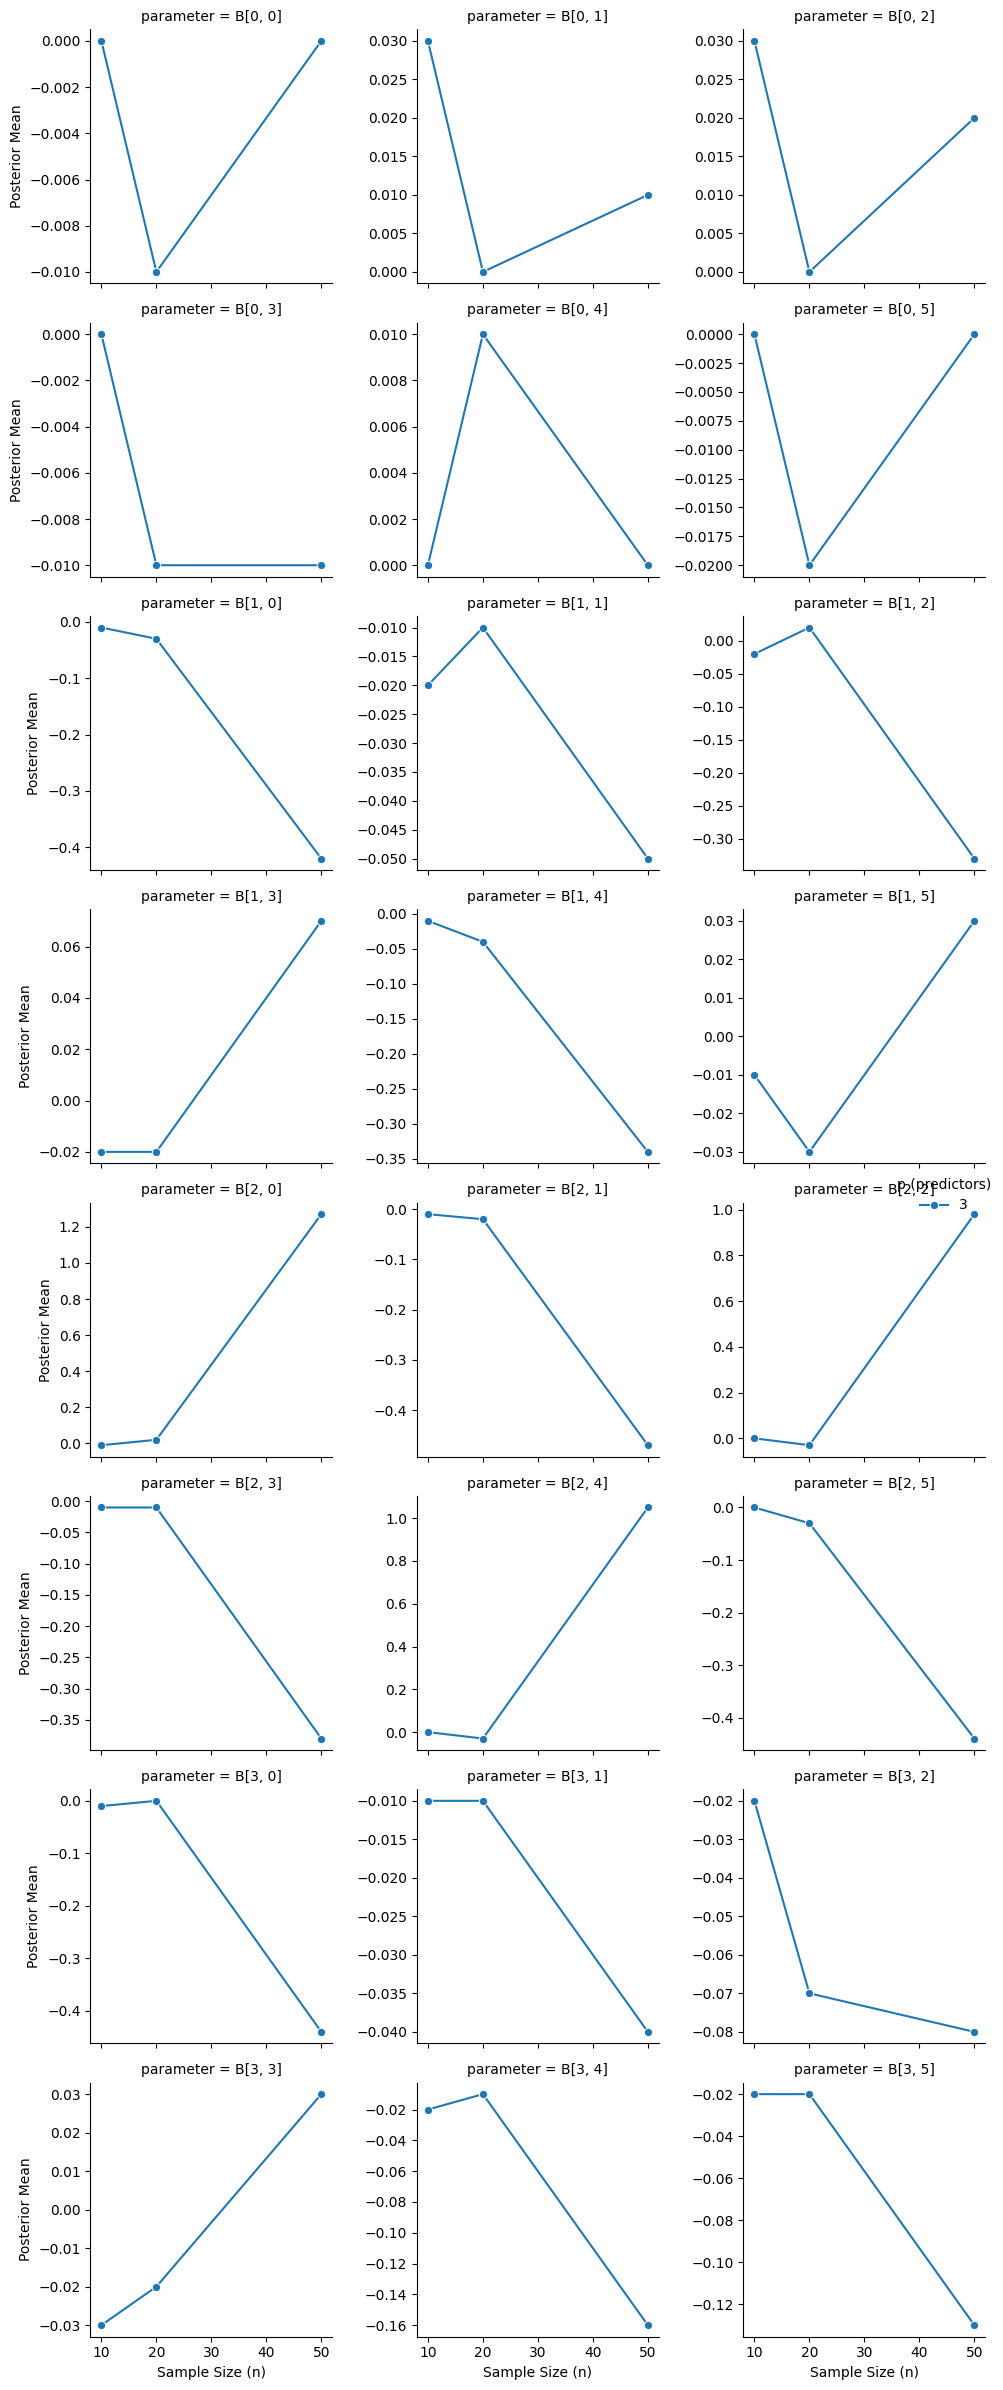

In [10]:
# Plot the posterior means vs sample size for each parameter.
import seaborn as sns

g = sns.FacetGrid(
    data=loan_betas_df,
    col="parameter",
    hue="p",
    sharey=False,
    col_wrap=3
)
g.map(sns.lineplot, "n", "mean", marker="o")
g.add_legend(title="p (predictors)")
g.set_axis_labels("Sample Size (n)", "Posterior Mean")
plt.tight_layout()
plt.show()

There are many changes between parameter values and sample sizes. Some parameters take a more linear posterior mean like B[3,3], while others are more triangular shaped like B[0,4]. We see that for some parameters the values for n=10 and n=20 are the same with a different n=30 and every combination of similar parameter posterior means for sample sizes exists. This emphasises the importance of sample size for parameter posterior means.

In [12]:
def one_fit_multivariate_classification(df, predictors, outcomes, draws=1000, tune=500):
    """
    Fits a Bayesian multivariate classification model using a latent variable approach
    with noncentered parameterization.

    The function:
      - Adds an intercept,
      - Standardizes the predictors,
      - Constructs design matrices X and Y,
      - For multiple binary outcomes, uses:
            B ~ Normal(0,1) for coefficients,
            An LKJCholeskyCov prior for latent covariance,
            z_raw ~ N(0,I) and defines Z = mu + dot(z_raw, L.T),
            and Bernoulli likelihoods with logit_p = Z[:, i] for each outcome.

    Returns the (model, trace, runtime).
    """
    # Work on a copy and add an intercept.
    df_temp = df.copy()
    df_temp["Intercept"] = 1.0
    pred_list = ["Intercept"] + predictors

    # Construct design matrices.
    X = df_temp[pred_list].values  # shape: (n, p)
    Y = df_temp[outcomes].values    # shape: (n, m)
    n, p_dim = X.shape
    m_dim = len(outcomes)

    # Standardize predictors.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    start_time = time.time()
    with pm.Model() as model:
        # For multiple binary outcomes, use the latent variable approach.
        B = pm.Normal("B", mu=0, sigma=1, shape=(p_dim, m_dim))
        mu = pm.math.dot(X_scaled, B)  # shape: (n, m_dim)

        # Define the Cholesky factor via an LKJ prior.
        packed_L = pm.LKJCholeskyCov(
            "packed_L",
            n=m_dim,
            eta=2.0,
            sd_dist=pm.Exponential.dist(1.0, shape=m_dim),
            compute_corr=False
        )
        L = pm.expand_packed_triangular(m_dim, packed_L)
        Sigma = pm.Deterministic("Sigma", L @ L.T)

        # Noncentered parameterization:
        # Sample z_raw ~ N(0,I) and define latent variable Z = mu + dot(z_raw, L.T)
        z_raw = pm.Normal("z_raw", mu=0, sigma=1, shape=(n, m_dim))
        Z = pm.Deterministic("Z", mu + pm.math.dot(z_raw, L.T))

        # Bernoulli likelihood for each outcome dimension using a logit link.
        for i in range(m_dim):
            pm.Bernoulli(f"Y{i}", logit_p=Z[:, i], observed=Y[:, i])

        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=4,
            target_accept=0.98,
            init="jitter+adapt_diag",
            random_seed=83
        )
    end_time = time.time()
    runtime = end_time - start_time

    return model, trace, runtime



In [13]:
# Downsample to n = 20 for final analysis.
df_sub = df.sample(n=20, random_state=42)
print(f"Using subset with {df_sub.shape[0]} observations.")

Using subset with 20 observations.


In [15]:
# Fit Model and Perform Inference for n = 20
model, trace, runtime = one_fit_multivariate_classification(df_sub, predictor_cols, outcome_cols, draws=1000, tune=500)
print(f"Model fitted in {runtime:.2f} seconds.")

# ------------------------------
# Bayesian Posterior Analysis & MCMC Diagnostics
# ------------------------------
# Summarize the posterior (for coefficients B and covariance Sigma).
summary = az.summary(trace, var_names=["B", "Sigma"], round_to=2)
print("Posterior Summary:")
print(summary)

# Print effective sample sizes and r_hat.
print("Effective Sample Size and R_hat:")
print(summary[["ess_bulk", "r_hat"]])


Output()

Model fitted in 118.81 seconds.
Posterior Summary:
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
B[0, 0]      -0.01   1.01   -1.83     1.90       0.01     0.02   4712.14   
B[0, 1]       0.00   0.98   -1.81     1.86       0.01     0.01   5107.14   
B[0, 2]       0.00   1.01   -1.82     1.94       0.01     0.02   5128.44   
B[0, 3]      -0.01   1.02   -1.93     1.90       0.02     0.02   4200.85   
B[0, 4]       0.01   1.01   -1.89     1.94       0.02     0.02   4435.25   
B[0, 5]      -0.02   1.01   -1.86     1.93       0.02     0.02   3614.38   
B[1, 0]      -0.03   0.81   -1.53     1.52       0.02     0.01   2556.82   
B[1, 1]      -0.01   0.80   -1.64     1.39       0.01     0.01   3376.06   
B[1, 2]       0.02   0.83   -1.55     1.56       0.02     0.01   2744.66   
B[1, 3]      -0.02   0.80   -1.46     1.53       0.01     0.01   3379.43   
B[1, 4]      -0.04   0.82   -1.69     1.38       0.02     0.01   2728.27   
B[1, 5]      -0.03   0.81   -1.62    

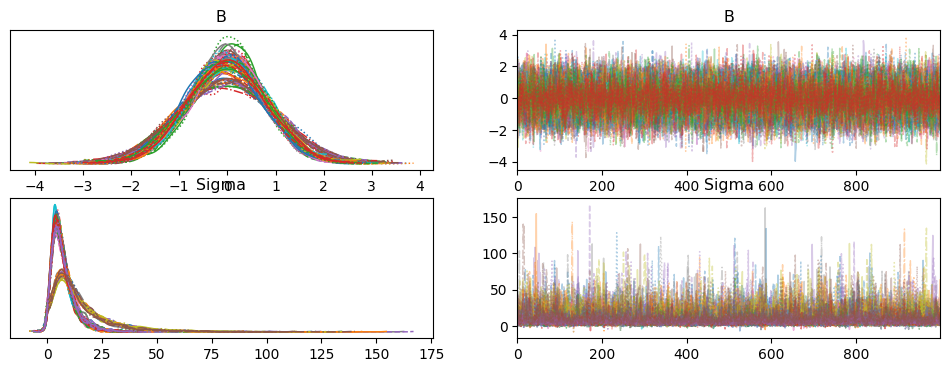

In [16]:
# Plot trace plots.
az.plot_trace(trace, var_names=["B", "Sigma"])
plt.show()

The coefficients B have well-defined unimodal posteriors, with chain traces that look stable and well-mixed.

The covariance Sigma is somewhat more variable, but the chains still appear to mix without obvious divergence. Some elements of Sigma show a peak near zero with a long tail, indicating that the model occasionally samples large variance or correlation values. This can sometimes happen multivariate models if the data doesn’t strongly rule out higher variance and thus may be the case in this dataset.